In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
loginsDF = pd.read_json('logins.json')
loginsDF.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
loginsDF.describe()

<ipython-input-3-d5521f93ca49>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  loginsDF.describe()


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


# Part One

Aggregate the login counts based on 15 minute interals. Visualize and describe the resulting time series of logins in ways that best characterize the underlying patterns of demand.

In [4]:
# Create a new dataframe containg the 15 minute intervals between the earliest time in the series and the latest.
rng = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
counts = np.zeros(len(rng))
stampsDF = pd.DataFrame(data={'timestamps':rng,'count':counts})
stampsDF.head()

,timestamps,count
0,1970-01-01 20:00:00,0.0
1,1970-01-01 20:15:00,0.0
2,1970-01-01 20:30:00,0.0
3,1970-01-01 20:45:00,0.0
4,1970-01-01 21:00:00,0.0


In [5]:
#Sort the original login times and reset the index
loginsDF = loginsDF.sort_values('login_time')
loginsDF.reset_index(inplace=True,drop=True)
loginsDF.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [6]:
nextStampInd = 1
for time in loginsDF['login_time']:
    sorting = True
    while sorting:
        if nextStampInd < len(stampsDF):
            if time < stampsDF['timestamps'].iloc[nextStampInd]:
                stampsDF.at[nextStampInd - 1, 'count'] += 1
                sorting = False
            else:
                nextStampInd += 1
        else:
            stampsDF.at[len(stampsDF)-1, 'count'] += 1
            sorting = False

In [7]:
stampsDF.head()

,timestamps,count
0,1970-01-01 20:00:00,2.0
1,1970-01-01 20:15:00,6.0
2,1970-01-01 20:30:00,9.0
3,1970-01-01 20:45:00,7.0
4,1970-01-01 21:00:00,1.0


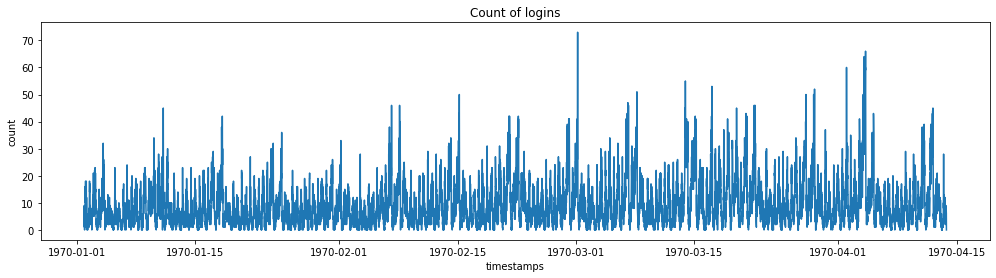

In [8]:
plt.figure(figsize=(17,4))
sns.lineplot(x = 'timestamps',y='count',data = stampsDF)
plt.title('Count of logins')
plt.show()

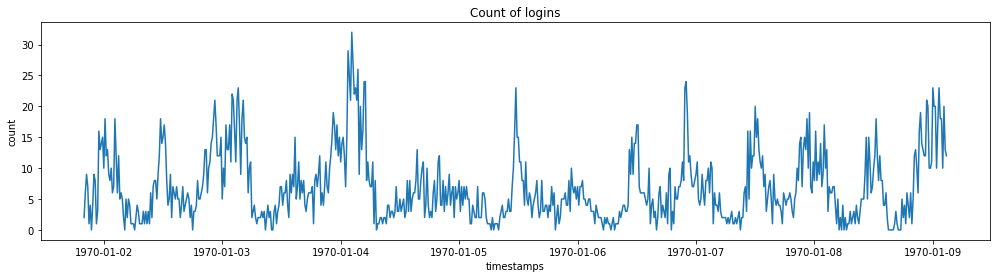

In [9]:
#zoom in on roughly the first week to see if we notice any trends
plt.figure(figsize=(17,4))
sns.lineplot(x = 'timestamps',y='count',data = stampsDF[0:700])
plt.title('Count of logins')
plt.show()

Looking at the data overall, it seems like one specific day of the week might have a spike, looking at just the first week, it seems as if there is a smaller spike roughly every 12 hours.

In [10]:
#find day of the week corresponding to the largest peak
stampsDF['count'].max()

73.0

In [11]:
ind = stampsDF[stampsDF['count'] == 73.0].index
stampsDF['timestamps'].iloc[ind[0]].dayofweek

6

We see that the maximal number of logins occured on a sunday. We check to see if sunday is consistently the day with the most logins.

In [12]:
len(stampsDF)/96/7

14.566964285714286

In [13]:
for i in range(14):
    tempInd = stampsDF[stampsDF['count'] == stampsDF['count'][i*96*7:(i+1)*96*7].max()].index
    print(stampsDF['timestamps'].iloc[tempInd[0]].dayofweek)

6
6
6
6
6
5
6
6
6
6
4
5
2
5


We see that generally Sunday is the most popular day, though the final month we see some variation. Weekends remain generally popular.

# Conclusion:

The data shows two notable trends. Firstly the data peaks every 12 hours, corresponding to early morning and early afternoon. Secondly, activity tends to build over the week, culminating with weekends being the busiest time.

There were no real data quality issues excepting perhaps the timestamps not being sorted.

# Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1 What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would look at weekend toll activity of drivers traveling to a city other than their home city. Due to opposite circadian rhythms, weekday toll information may not be conclusive as it would require a driver to work without sleep. Weekend activity is equal in the two cities so we are more likely to observe traffic between the two cities at any given time.

2 Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

We must first begin by tracking toll information before the change goes into effect so we have a control to compare against. We then announce the change and continue to track driver location, with a specific intrerest in how many times per day a driver changes cities and how often drivers are spending time in the city that isn't their home city.

b) what statistical test(s) you will conduct to verify the significance of the observation

 I would then use a t-test to compare trips back and forth in my control and with the updated policy focusing specifically on weekends when it is likely that a resident will want to go from one city to the other as they have overlapping active hours. I would compute the effect size of the change in policy so we know if the change is having a meaningful impact.

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If we see an effect size of greater than .25 we perform actual cost analysis to determine if the loss in tolls is outweighed by the increased revnue of driver overlap. If we find that the program is profitable I would recommend keeping it. It is also possible that, with a high enough effect size, the program is so useful for citizens that even if it results in lower profits, it may be worth the increased flow in business.

# Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [14]:
ultimate_df = pd.read_json('ultimate_data_challenge.json')
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [16]:
ultimate_df[['last_trip_date','signup_date']].describe()

,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29,2014-01-18
freq,2036,2948


In [17]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
# signup date and last trip date are currently strings not datetimes
#make them datetimes
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [19]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [20]:
#create a list of Trues and Falses representing if a user is retained or not based on a date 6 months after their first trip.
#if their last trip is within 30 days of this 6 month mark, they count as retained

active_users = []
for i in range(len(ultimate_df)):
    st = ultimate_df['signup_date'][i] #get start date
    et = st + pd.Timedelta('181D') #6 months later
    at = et - pd.Timedelta('30D') #set point 30 days prior
    if at <= ultimate_df['last_trip_date'][i] <= et:
        active_users.append(True) # now that the active condition has been met, set active user to True
    else:
        active_users.append(False)

In [21]:
ultimate_df['retained'] = active_users

In [22]:
ultimate_df['retained'].value_counts()

False    37802
True     12198
Name: retained, dtype: int64

In [23]:
print('Percentage retained: '+str(12198/50000*100)+'%')

Percentage retained: 24.396%


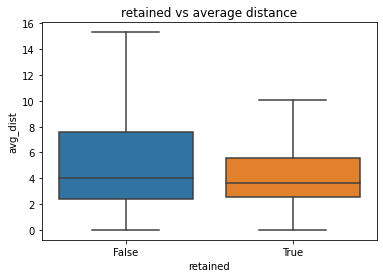

In [24]:
sns.boxplot(x='retained',y='avg_dist',data=ultimate_df,showfliers=False)
plt.title('retained vs average distance')
plt.show()

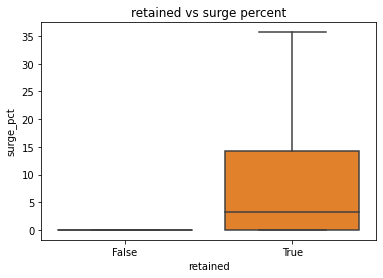

In [25]:
sns.boxplot(x='retained',y='surge_pct',data=ultimate_df,showfliers=False)
plt.title('retained vs surge percent')
plt.show()

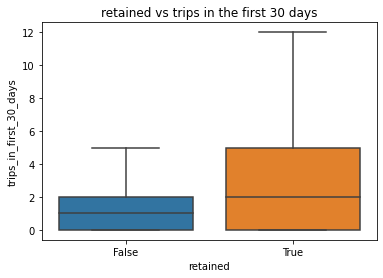

In [26]:
sns.boxplot(x='retained',y='trips_in_first_30_days',data=ultimate_df,showfliers=False)
plt.title('retained vs trips in the first 30 days')
plt.show()

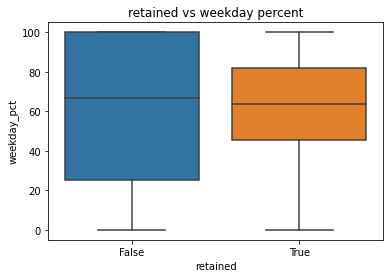

In [27]:
sns.boxplot(x='retained',y='weekday_pct',data=ultimate_df,showfliers=False)
plt.title('retained vs weekday percent')
plt.show()

From our graphs above, it appears as if a lower average distance and a higher number of trips in the first 30 days have a correlation with retention. Noteably, basically any percentage of trips taken during surge pricing correlates to being a retained user which matches the intuitive though process that a frequent user is more likely to purchase rides for a higher than normal price than a one time or low time user. While we may have expected weekday percent to be a strong indicatior of regular users, there appears to be little to no correlation between the two.

In [28]:
# Table of ultimate balck vs active
ub_active = pd.crosstab(index=ultimate_df["retained"], 
                            columns=ultimate_df["ultimate_black_user"],
                             margins=True)   # Include row and column totals

ub_active.columns = ["Not Ultimate Black","Is Ultimate Black","rowtotal"]
ub_active.index= ["Not Active","Is Active","coltotal"]

ub_active

,Not Ultimate Black,Is Ultimate Black,rowtotal
Not Active,25204,12598,37802
Is Active,5942,6256,12198
coltotal,31146,18854,50000


Ultimate Black looks like a good feature to include as more than half of retained users are ultimate black users but less than 40% of overall users are ultimate black users. This is a significant jump in frequency.

# Build a predictive Model

In [29]:
#transforming categorical features into numerical for predictive modeling
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['Astapor',"King's Landing",'Winterfell'])
LE = preprocessing.LabelEncoder()
LE.fit(['iPhone','Android'])

LabelEncoder()

In [30]:
ultimate_df.dropna(inplace=True)

In [31]:
creation1 = le.transform(ultimate_df['city']) #transform the categorical data into number labels
creation2 = LE.transform(ultimate_df['phone'])

In [32]:
ultimate_df['city'] = creation1
ultimate_df['phone'] = creation2

In [33]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,1,4,2014-01-25,4.7,1.10,2014-06-17,1,15.4,True,46.2,3.67,5.0,False
1,0,0,2014-01-29,5.0,1.00,2014-05-05,0,0.0,False,50.0,8.26,5.0,False
2,0,3,2014-01-06,4.3,1.00,2014-01-07,1,0.0,False,100.0,0.77,5.0,False
3,1,9,2014-01-10,4.6,1.14,2014-06-29,1,20.0,True,80.0,2.36,4.9,True
4,2,14,2014-01-27,4.4,1.19,2014-03-15,0,11.8,False,82.4,3.13,4.9,False


In [34]:
#splitting into features and target
y = ultimate_df['retained']
X = ultimate_df[['avg_dist','avg_surge','trips_in_first_30_days', 'city', 'phone','ultimate_black_user']]

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11681   371]
 [ 3951   575]]
              precision    recall  f1-score   support

       False       0.75      0.97      0.84     12052
        True       0.61      0.13      0.21      4526

    accuracy                           0.74     16578
   macro avg       0.68      0.55      0.53     16578
weighted avg       0.71      0.74      0.67     16578



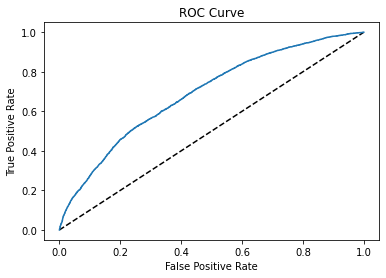

In [36]:

from sklearn.metrics import roc_curve

# Compute predicted probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute and print AUC score
print("AUC: "+str(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv = 5,scoring = 'roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: "+str(cv_auc))

AUC: 0.6908275400793058
AUC scores computed using 5-fold cross-validation: [0.69605242 0.69151089 0.68947357 0.69661159 0.70498244]


In [38]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
# Instantiate a logistic regression classifier
logreg = LogisticRegression()

# Instantiate the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: "+str(logreg_cv.best_params_)) 
print("Best score is "+str(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.05179474679231213}
Best score is 0.7425744963204247


In [39]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [40]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# fit model to training data
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[11:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

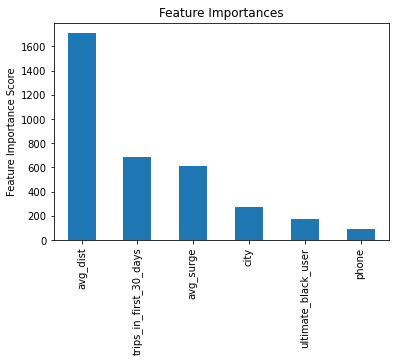

In [41]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

In [42]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.92%
